# Single Cell Sequencing: data analysis II function (campari information)

Here we use information from function and campari to check our clustering.


In [1]:
!pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')
from matplotlib import rcParams


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/melma31/mambaforge/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepreca

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.10


## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [2]:
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'
input_path = '/home/melma31/Documents/single_cell_sequencing/output/'

adata = ad.read_h5ad(input_path + 'campari_scs_umap.h5ad')

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## SECTION II: Funtional exploration

Now we add the information we have about stimuli for each cell and level of campari green and red fluorecence. 

Here we define the stimuli that were used (this assignation of number and id is the one that is used in the plate information excel sheet): 


* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: tomatoe
* 12: poop

In [7]:
rcParams['figure.figsize']=(4,4)

labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']
color = ['gainsboro','green','darkorange','purple','magenta','cyan','red','orange','yellow','brown','orange','blue','violet','k']


### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x = adata.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]



/tmp/ipykernel_4581/475451686.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stim[i] = adata.obs['stimulus'][i]
/tmp/ipykernel_4581/475451686.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  red[i] = adata.obs['red'][i]
/tmp/ipykernel_4581/475451686.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  green[i] = adata.obs['green'][i]


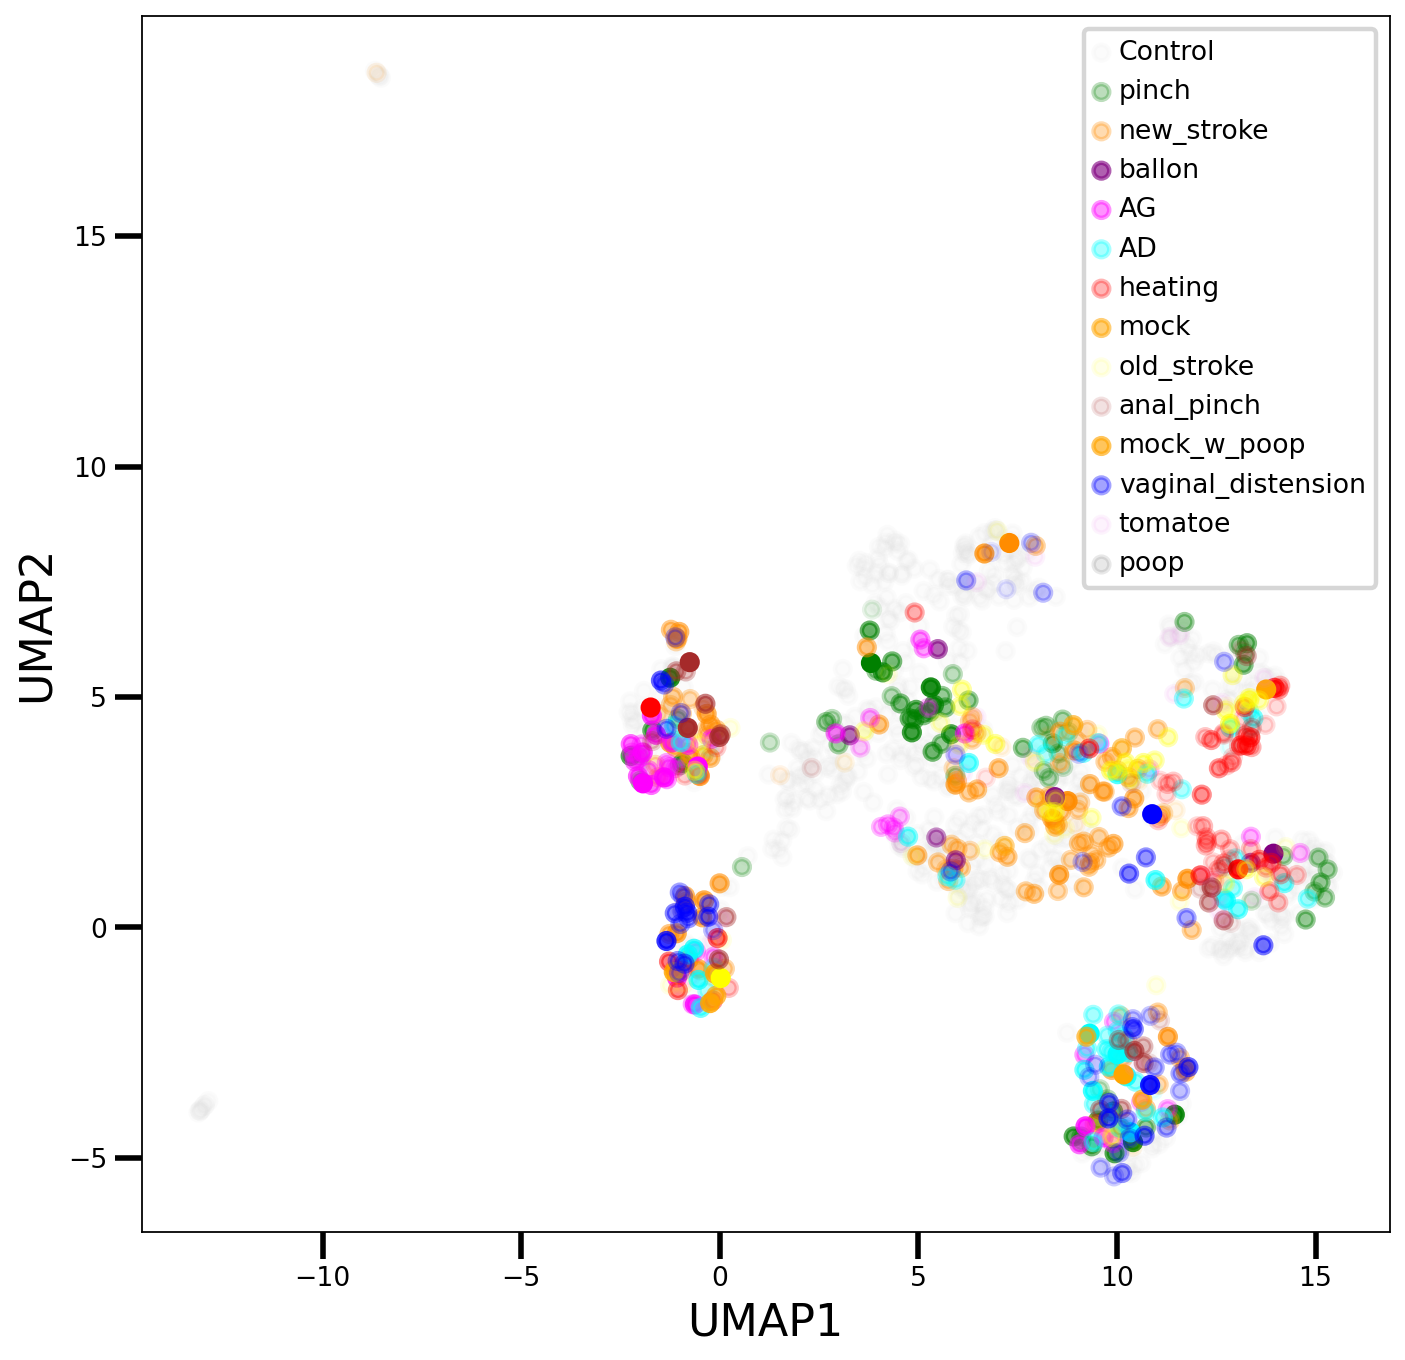

In [8]:
### plotting all stimulus together

figure, axes = plt.subplots()
#red_norm = (red - np.min(red)) / (np.max(red) - np.min(red))
for i in range(len(labels)):
    index = np.where(stim == i)[0]
    red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
    red_norm = (red_norm + 0.1)/1.1
    axes.scatter(adata.obsm['X_umap'][index,0],adata.obsm['X_umap'][index,1], s = 50, c = color[i], alpha = red_norm)
axes.grid(visible = 'None')
#axes.set_xlim([0,19])
#axes.set_ylim([0,19])
axes.set_xlabel('UMAP1', fontsize = 20)
axes.set_ylabel('UMAP2', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.tick_params(axis='both', which='minor', labelsize=12)
axes.grid(False)

axes.legend(labels, fontsize = 12)
#sc.pl.umap(adata, color = 'stimulus', color_map = 'Set1', save = 'stimulus'+ '.png', size = 180)
figure.set_size_inches([10,10])
figure.savefig(figure_path + 'stimulus.png')

(629, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


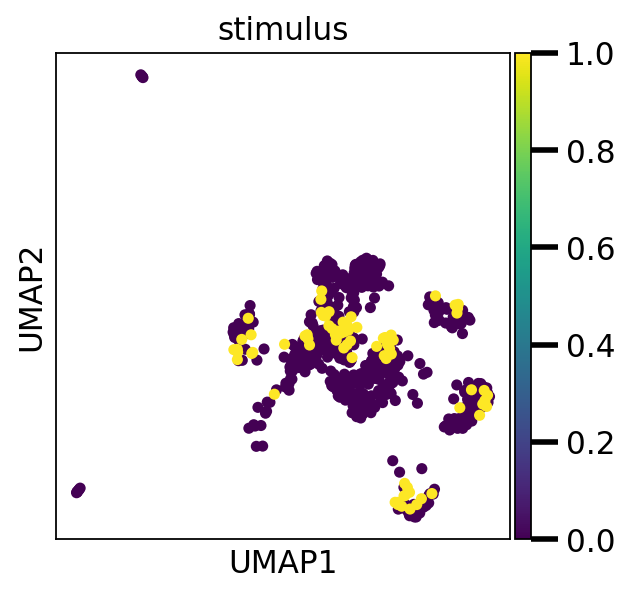

(686, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


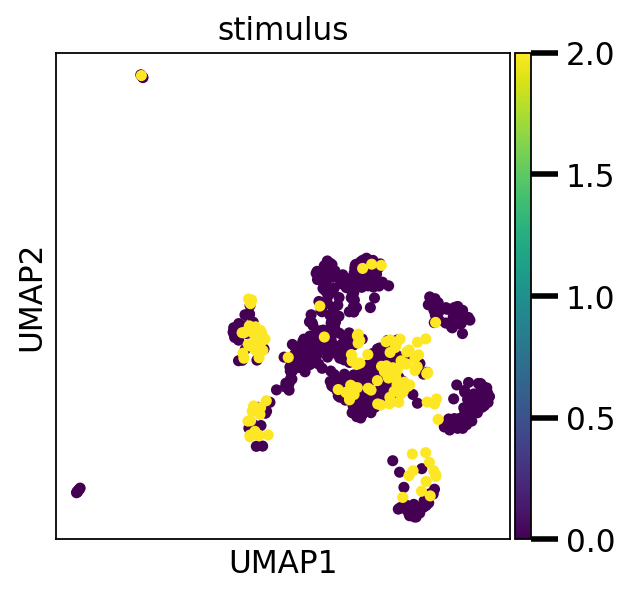

(561, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


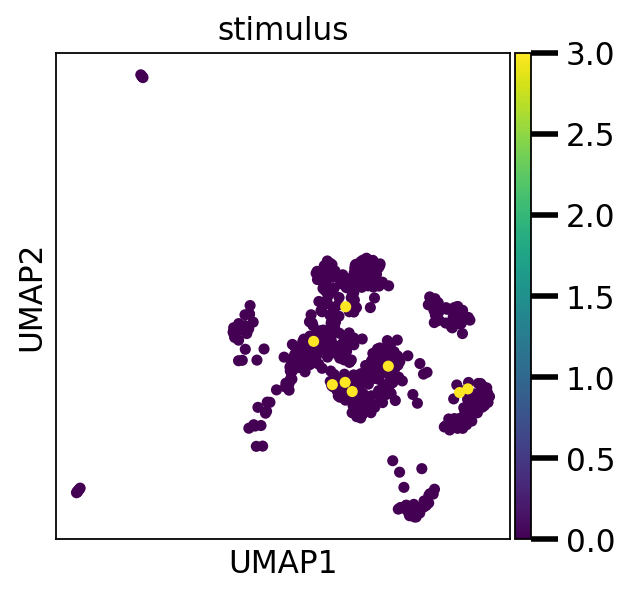

(604, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


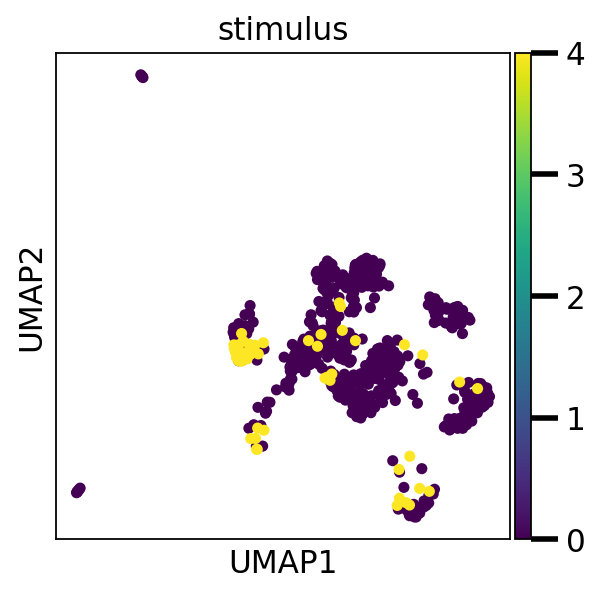

(614, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


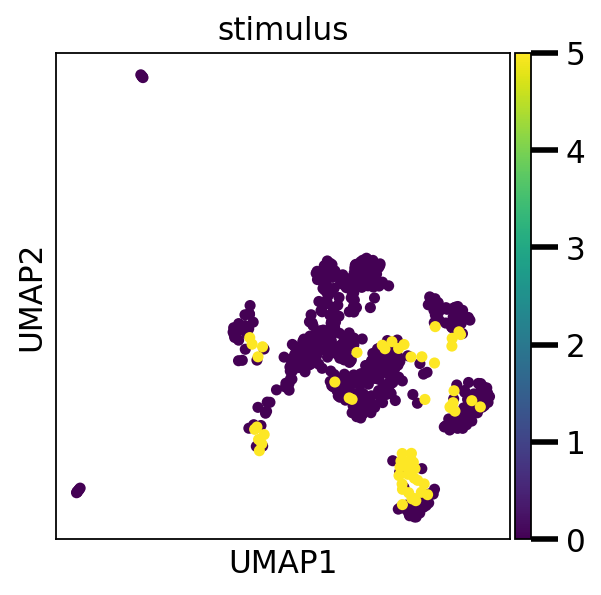

(616, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


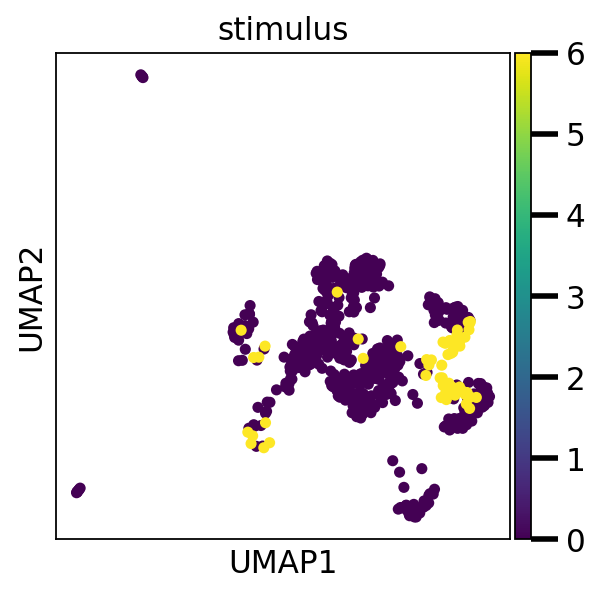

(569, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


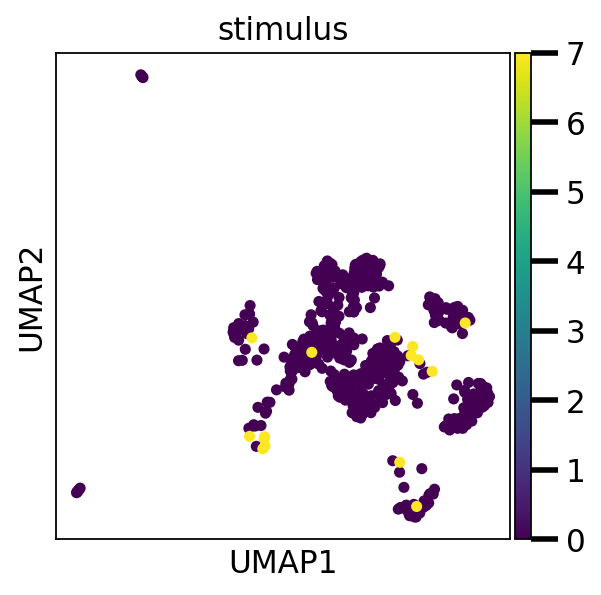

(608, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


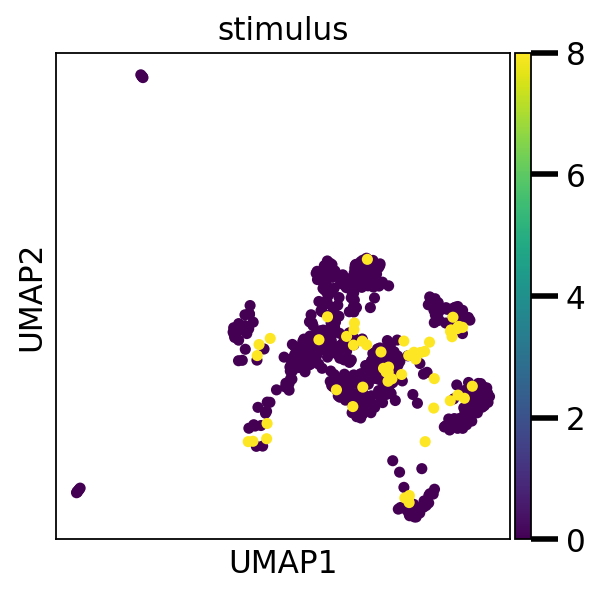

(585, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


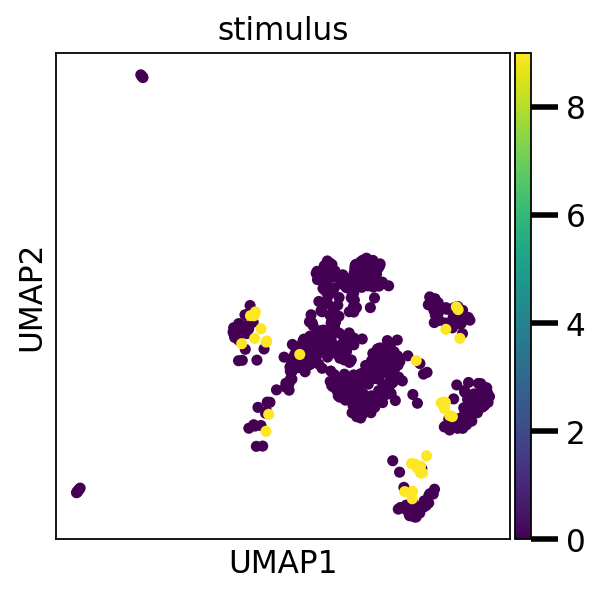

(557, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


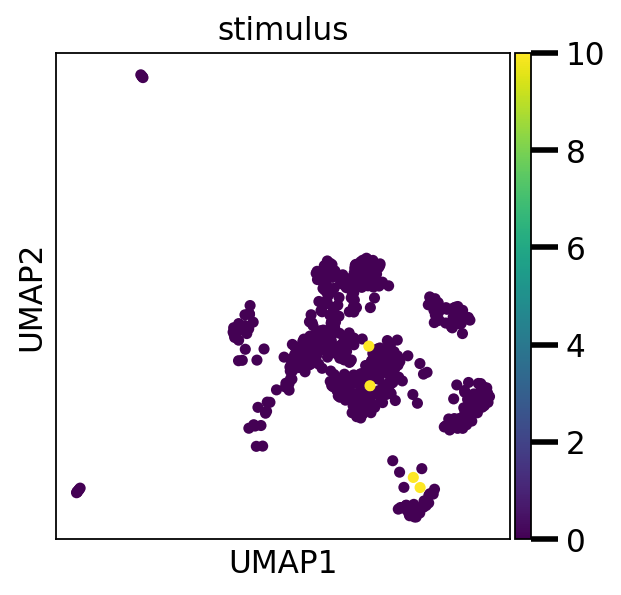

(612, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


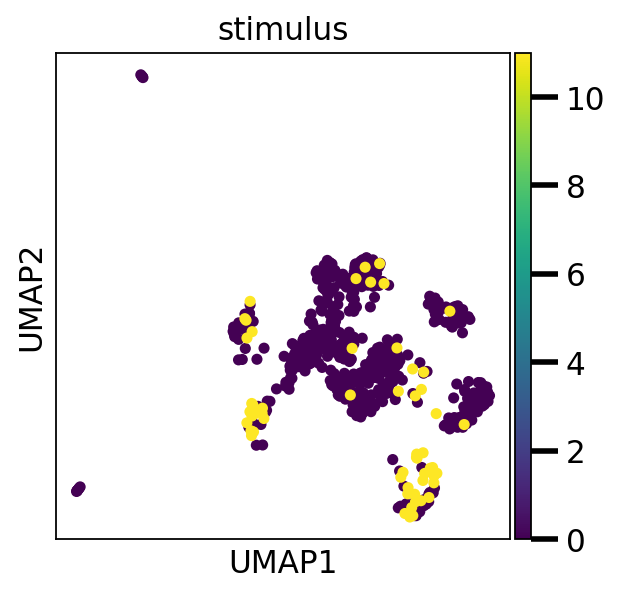

(575, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


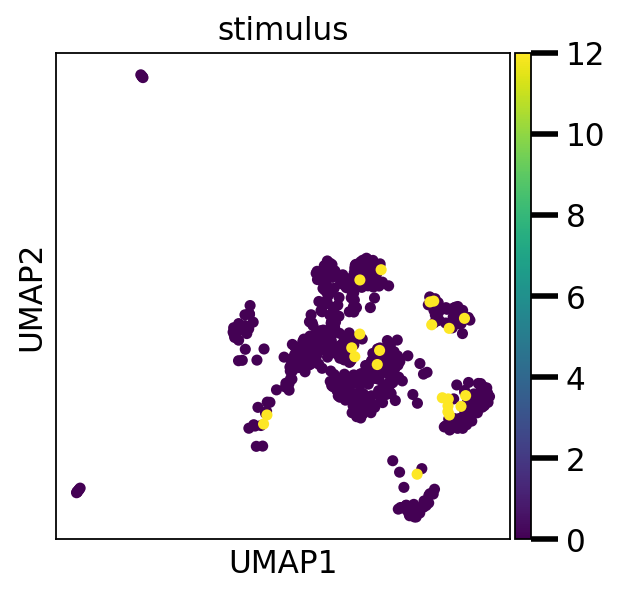

(554, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


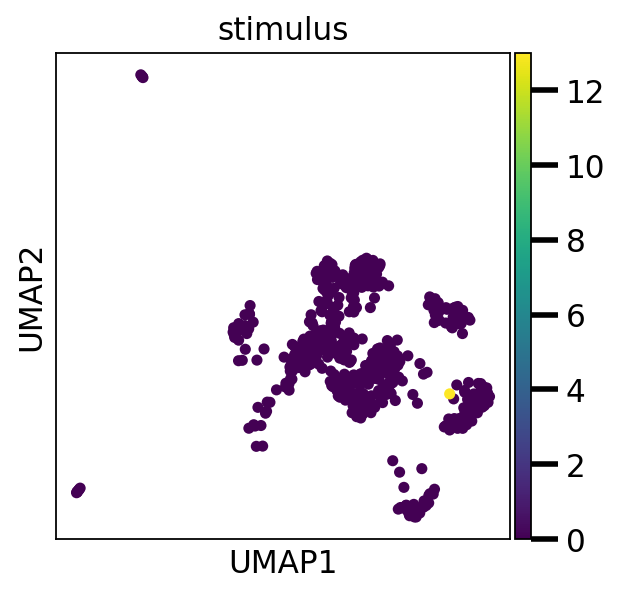

In [9]:
### plotting stimuli individualy

rcParams['figure.figsize']=(4,4)

for i in range(1,14):
    index = np.logical_or(adata.obs['stimulus'] == i,adata.obs['stimulus'] == 0)
    aux_adata = adata[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'stimulus', color_map = 'viridis', save = 'UMIs/stimulus/stimulus_' + labels[i]+ '.png', size = 100)

0
[]
4
[0]
5
[0, 4]
2
[0, 4, 5]
1
[0, 4, 5, 2]
9
[0, 4, 5, 2, 1]
6
[0, 4, 5, 2, 1, 9]
11
[0, 4, 5, 2, 1, 9, 6]
12
[0, 4, 5, 2, 1, 9, 6, 11]


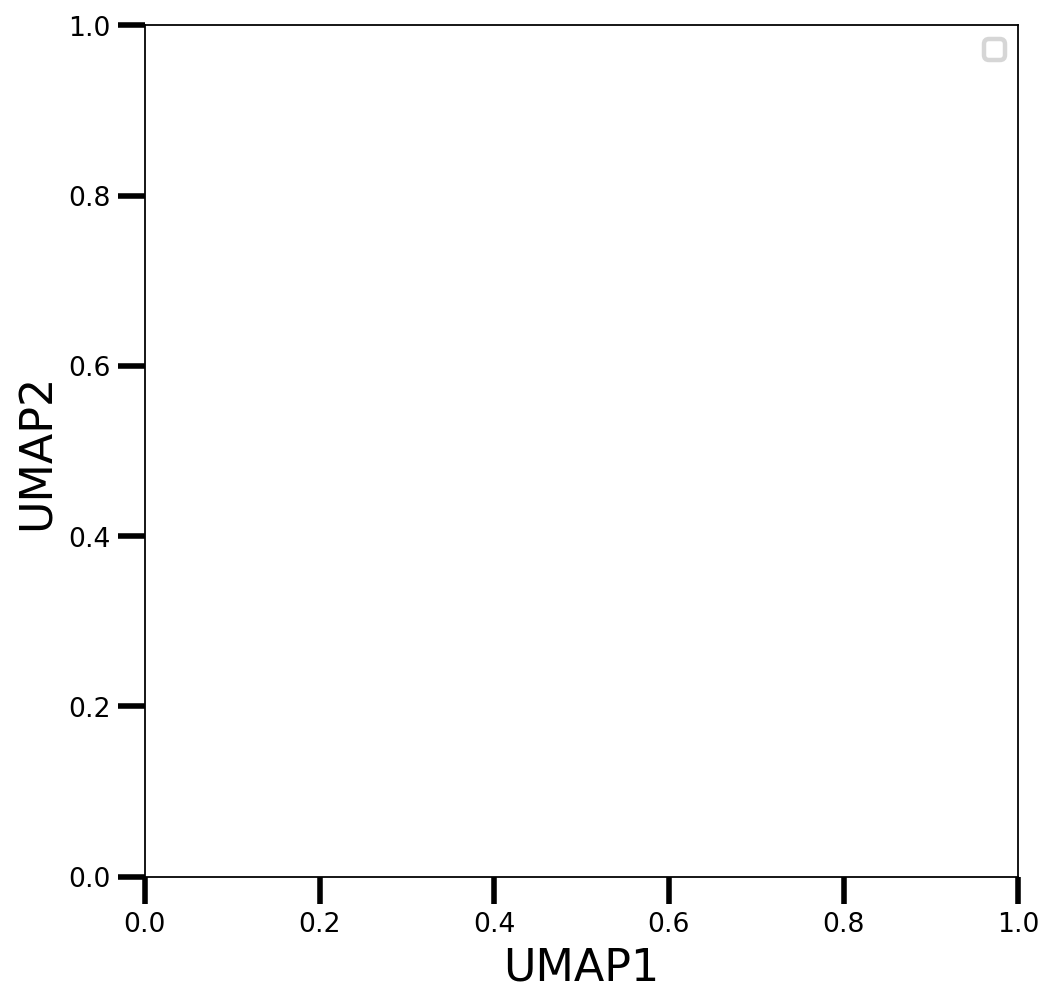

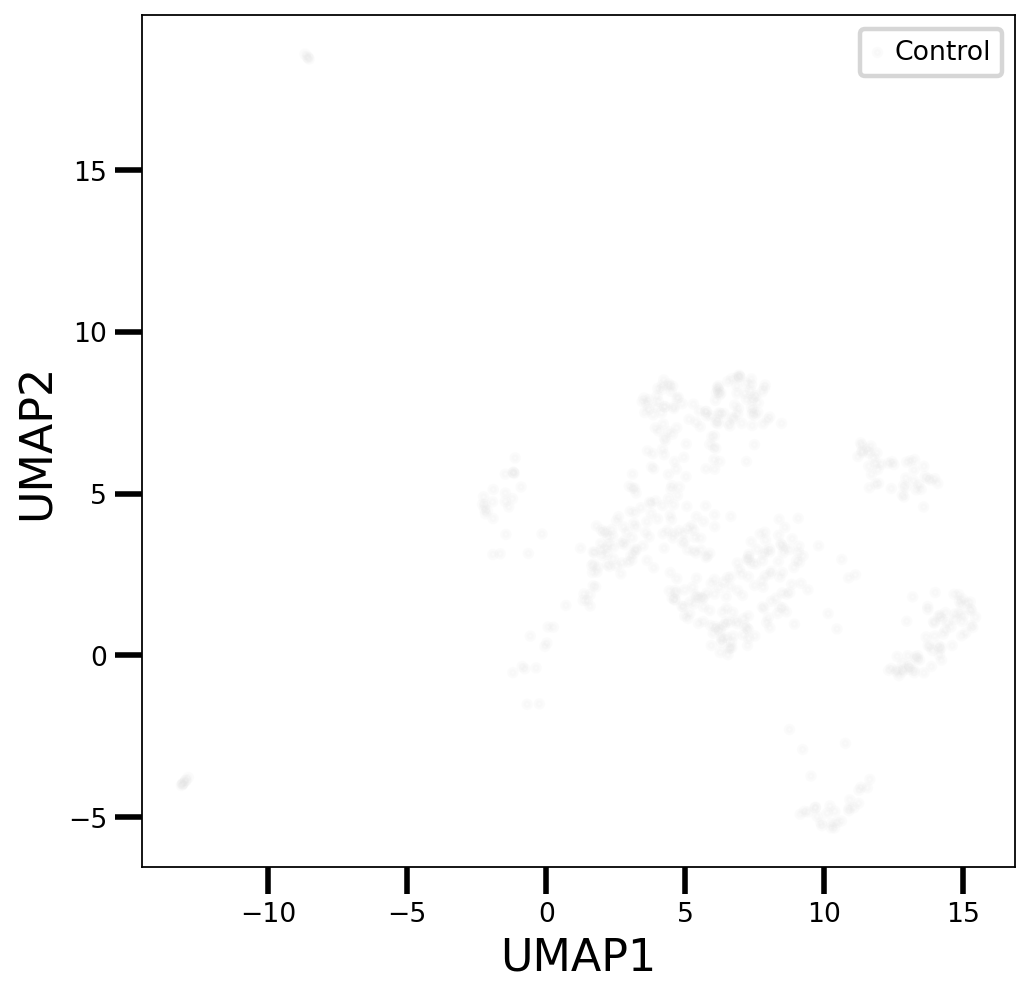

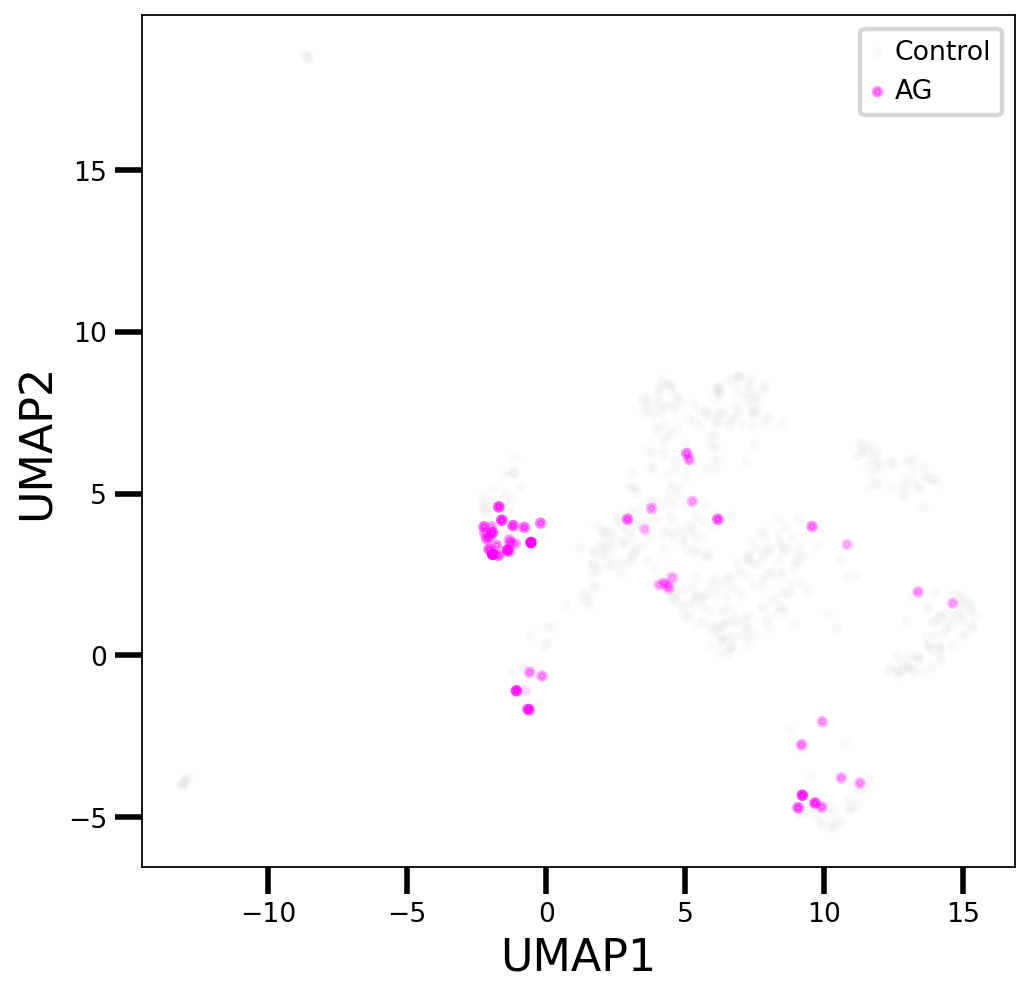

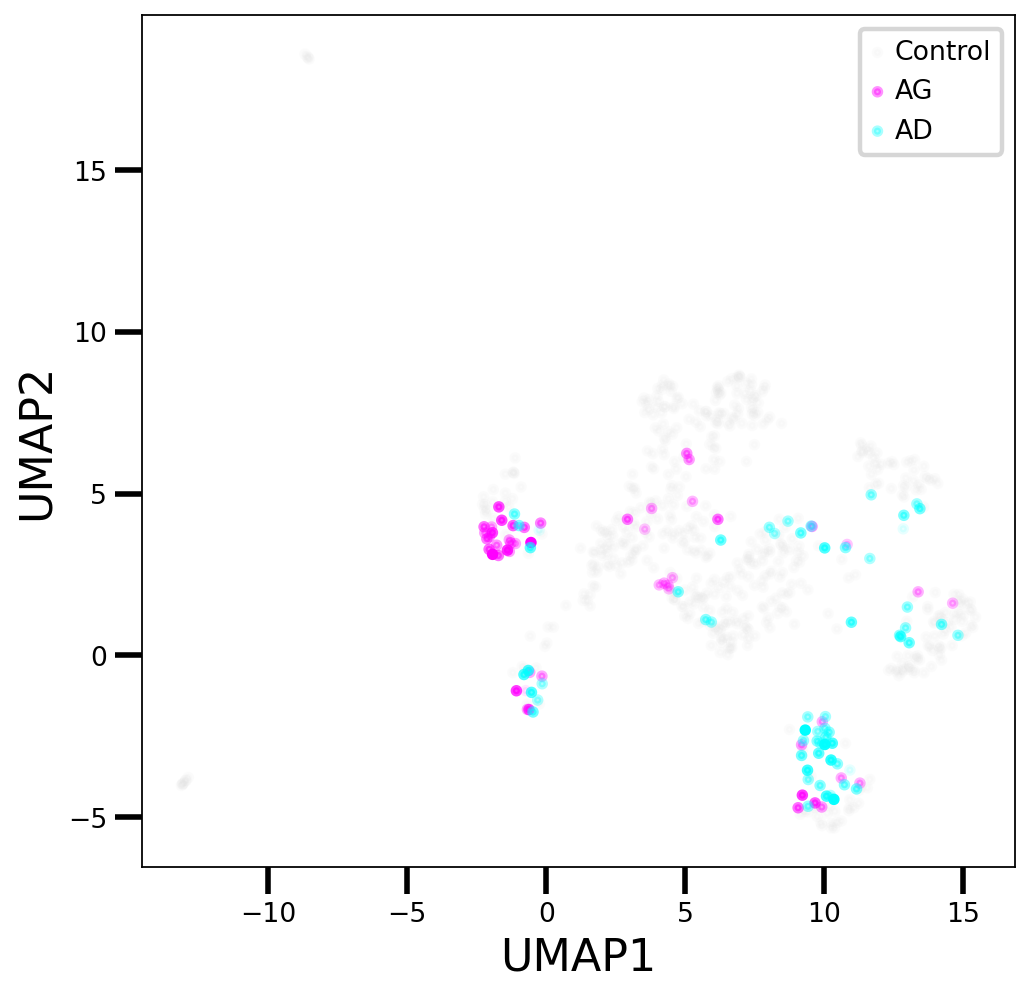

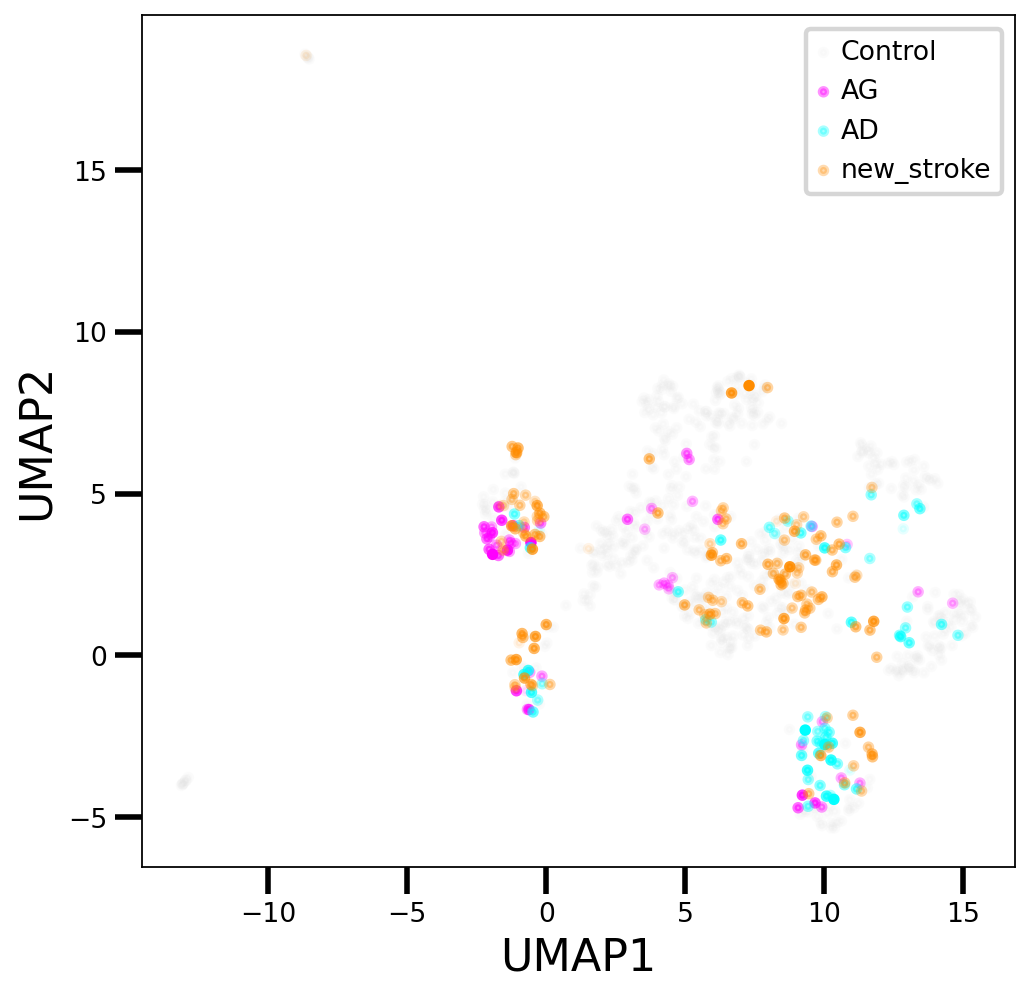

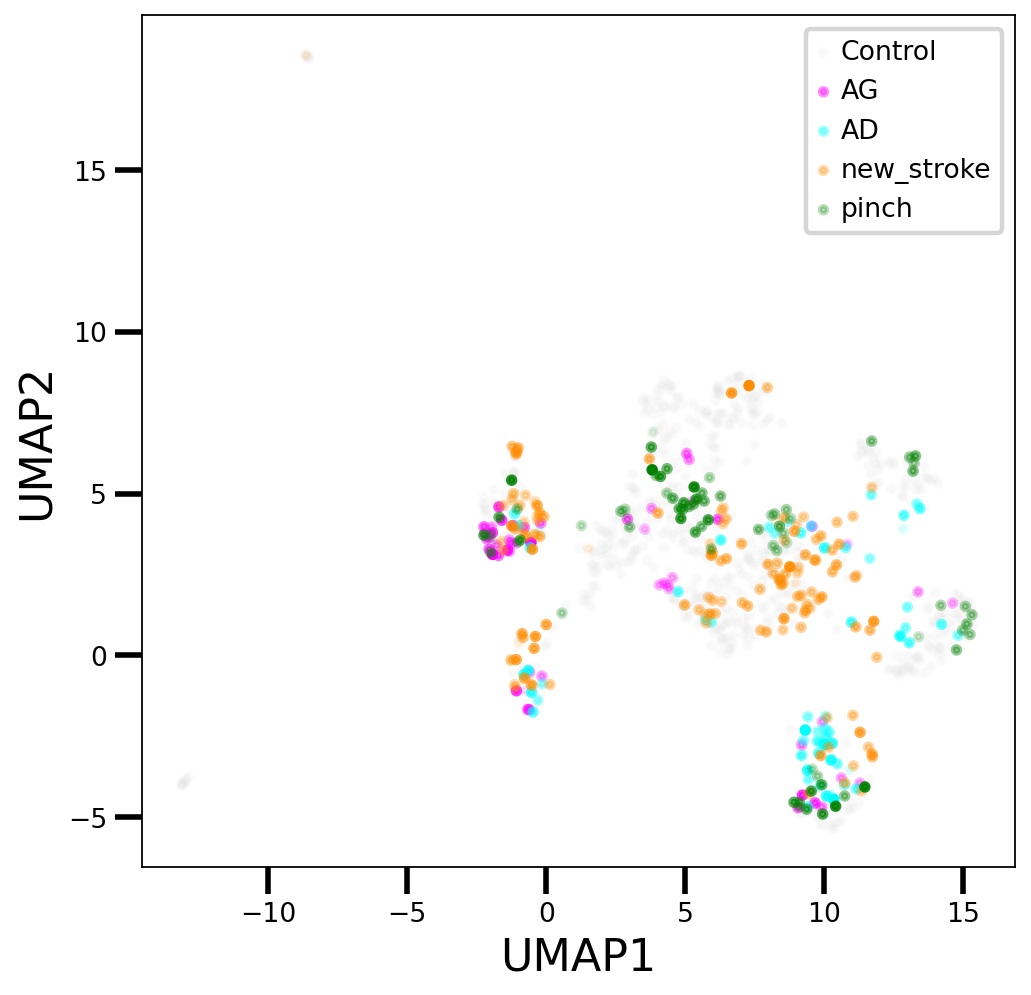

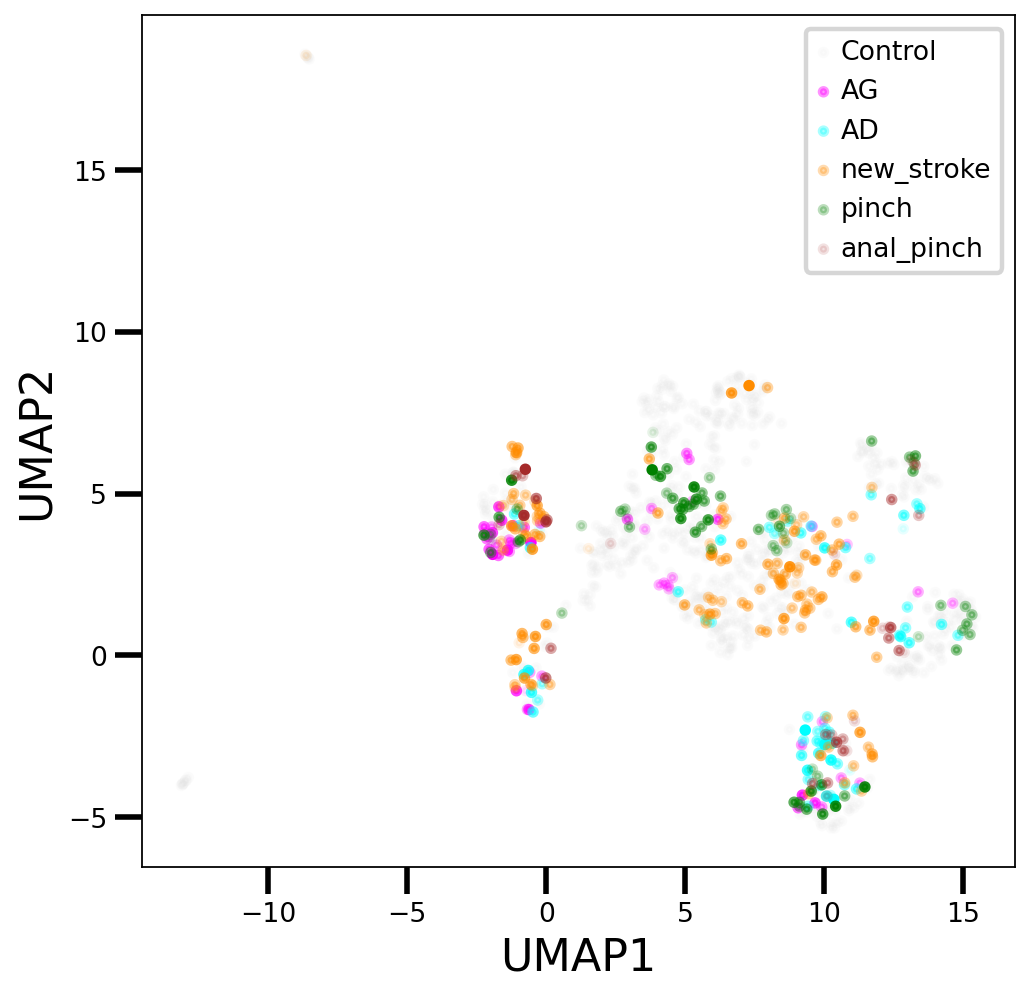

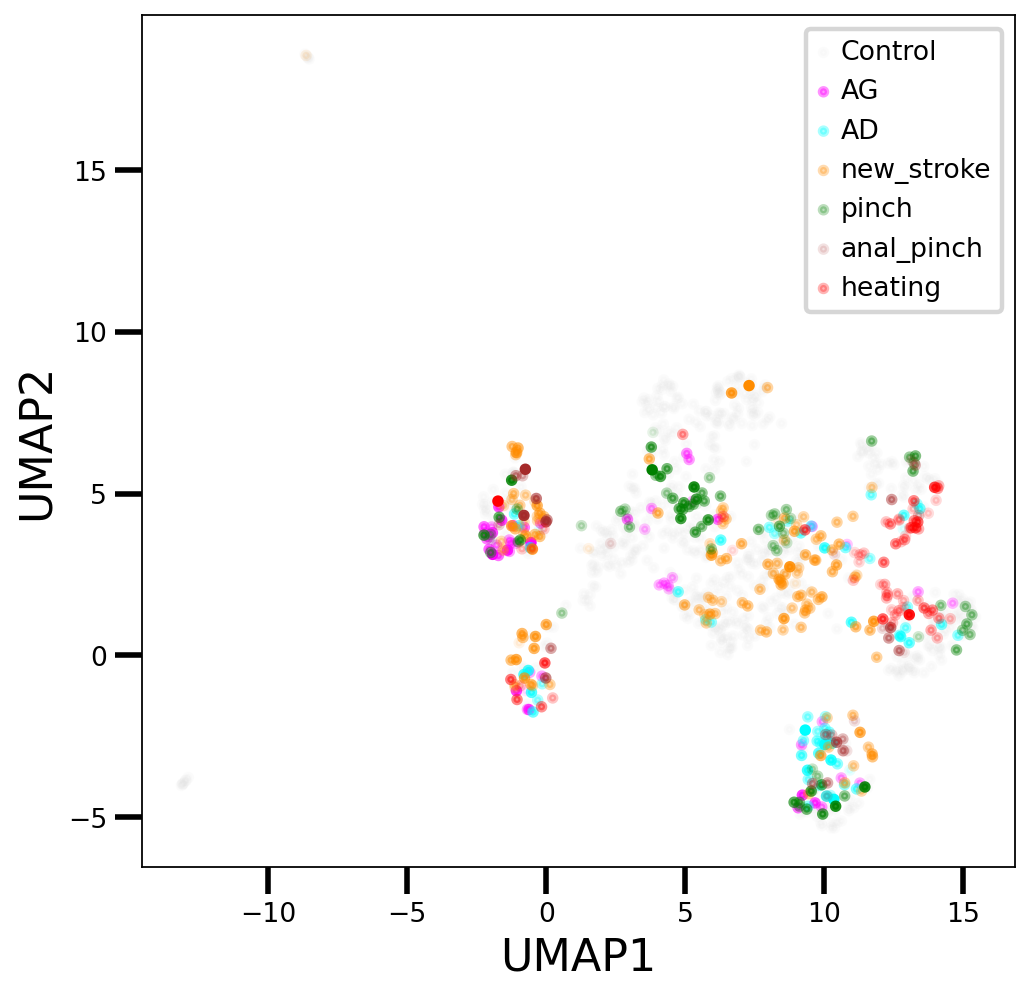

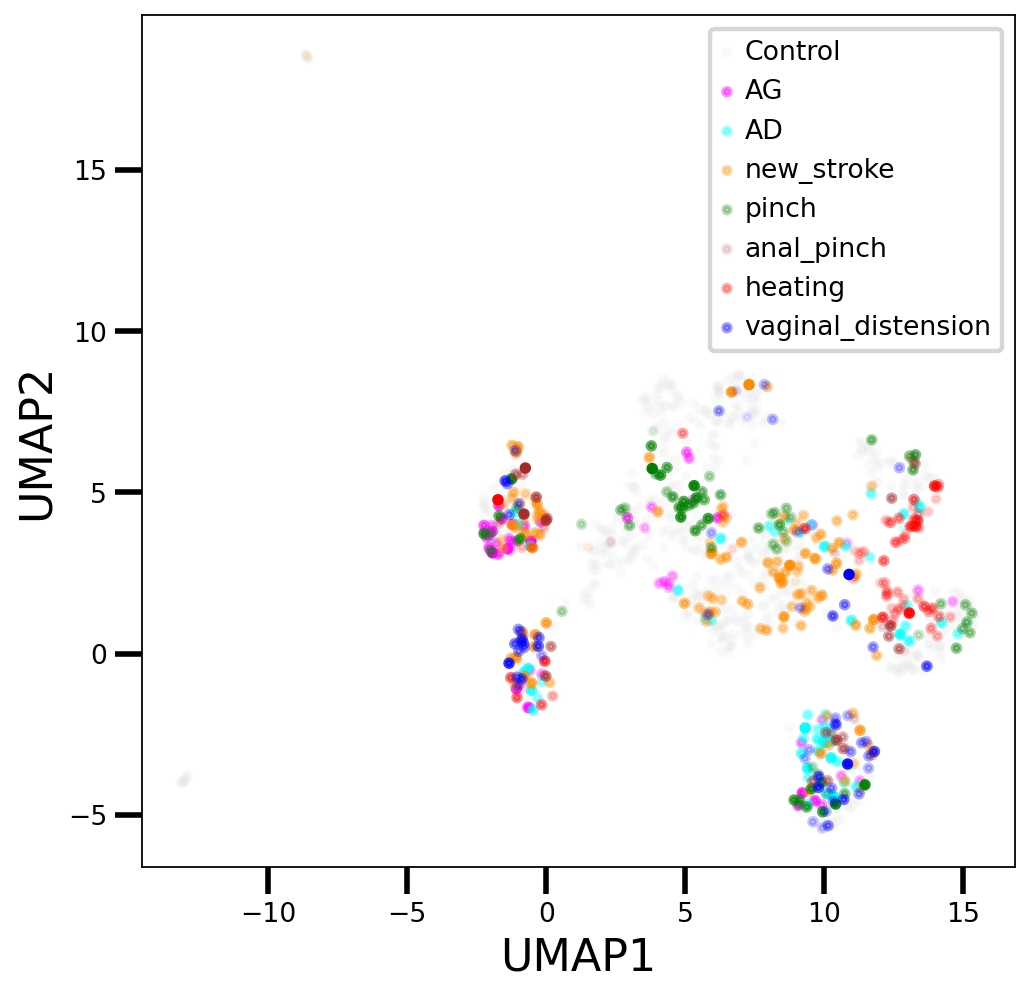

In [10]:
### plotting subsequent stimulus to add individually in a gif (only for selected stimuli)
stimulus_list = [0,4,5,2,1,9,6,11,12]
new_labels=['Control','AG','AD','new_stroke','pinch','anal_pinch','heating','vaginal_distension','non']
count = 0
for i in stimulus_list:
    print(i)
    figure, axes = plt.subplots()
    sublist = stimulus_list[0:count]
    print(sublist)
    for j in sublist:
        index = np.where(stim == j)[0]
        red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
        red_norm = (red_norm + 0.1)/1.1
        axes.scatter(adata.obsm['X_umap'][index,0],adata.obsm['X_umap'][index,1], s = 10, c = color[j],alpha = red_norm)

    axes.grid(visible = 'None')
    #axes.set_xlim([0,22])
    #axes.set_ylim([0,22])
    axes.set_xlabel('UMAP1', fontsize = 20)
    axes.set_ylabel('UMAP2', fontsize = 20)
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.tick_params(axis='both', which='minor', labelsize=12)
    axes.grid(False)
    axes.legend(new_labels, fontsize = 12)
    figure.set_size_inches([7,7])
    figure.savefig(figure_path + 'cum_stimulus'+ str(count) +'.png')

    count = count +1 

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


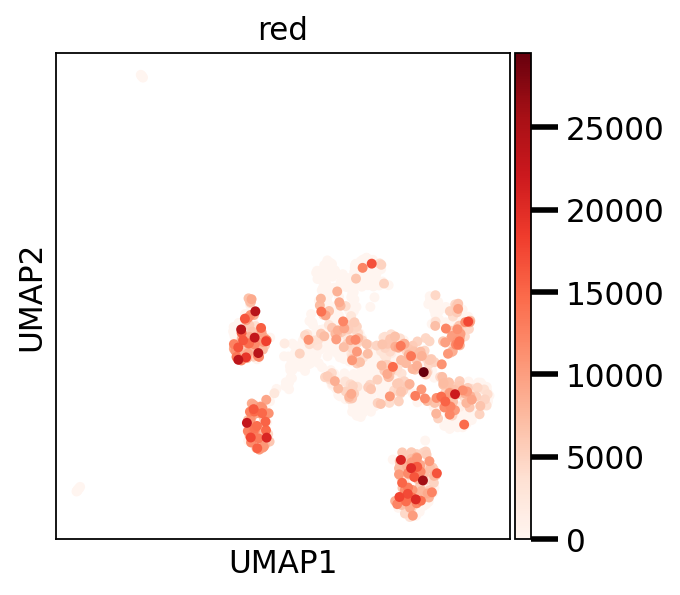

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


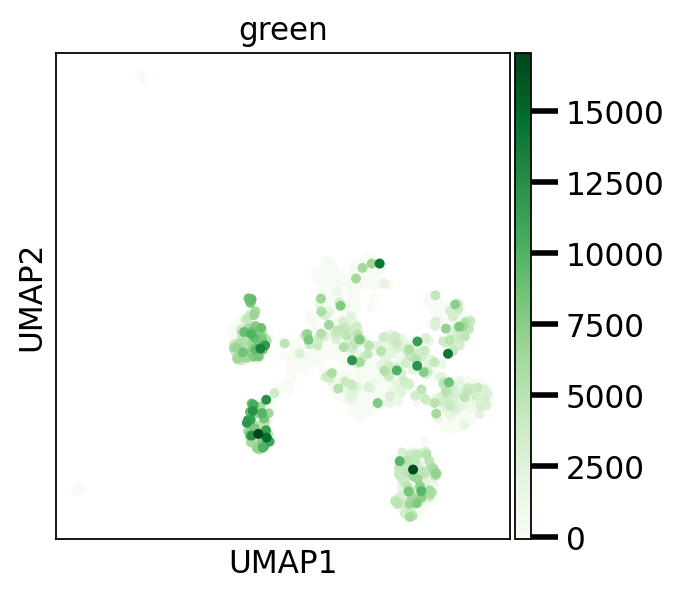

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


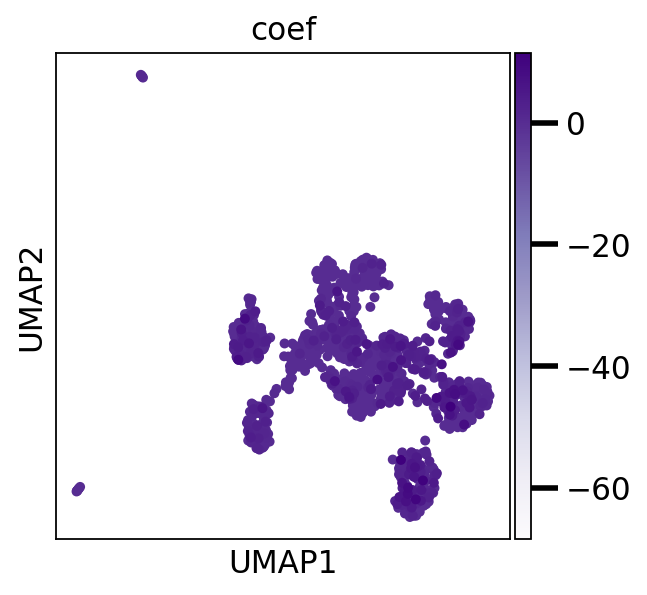

In [11]:
### plotting fluorecence levels 

sc.pl.umap(adata, color='red', color_map = 'Reds', save = 'UMIs/fluorecence/red_f' + '.png', size = 80)
sc.pl.umap(adata, color='green', color_map = 'Greens', save = 'UMIs/fluorecence/green_f' + '.png', size = 80)
adata.obs['coef'] = adata.obs['red']/(adata.obs['green'] + sys.float_info.epsilon)
sc.pl.umap(adata, color='coef', color_map = 'Purples', save = 'UMIs/fluorecence/coef_f' + '.png', size = 80)


(629, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


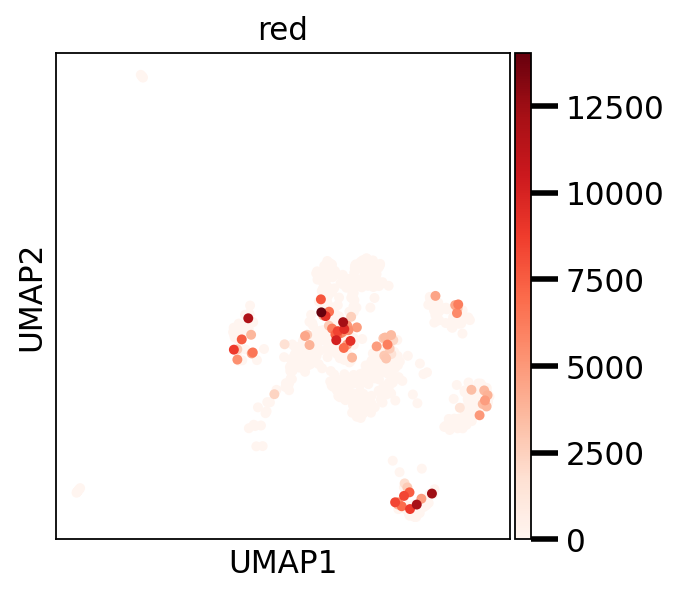

(686, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


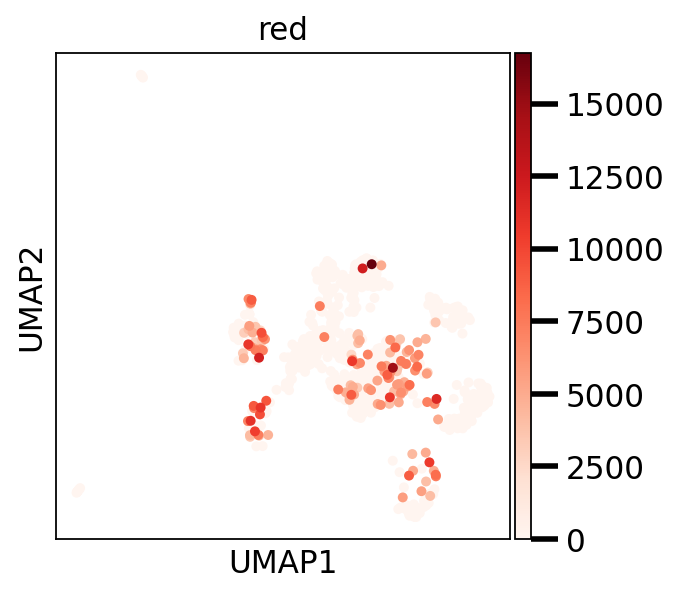

(561, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


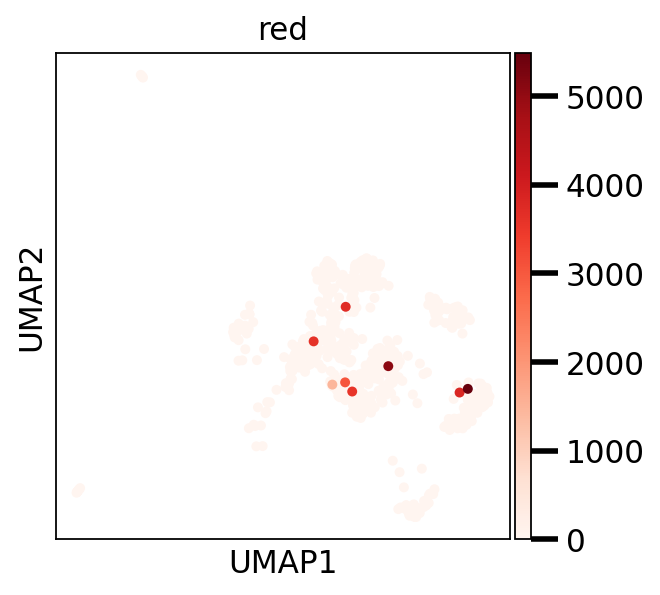

(604, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


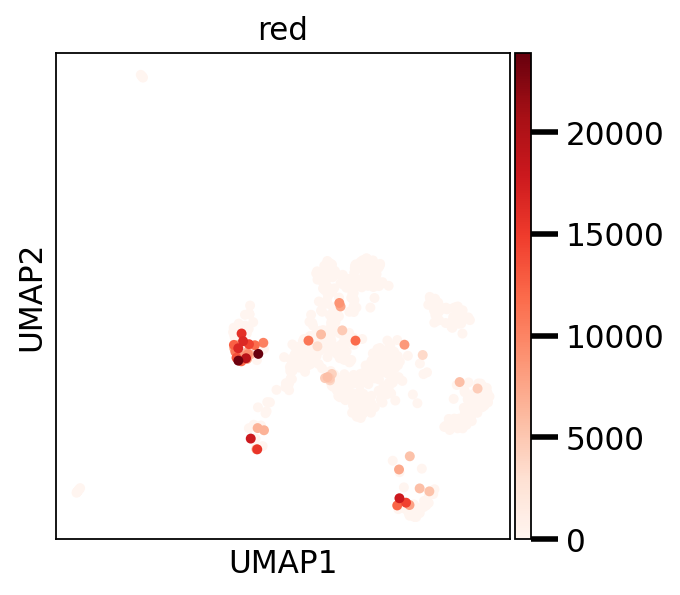

(614, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


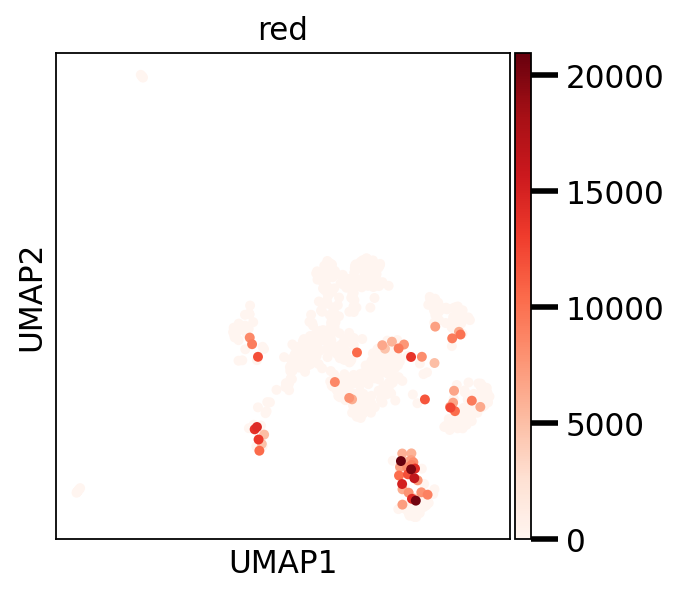

(616, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


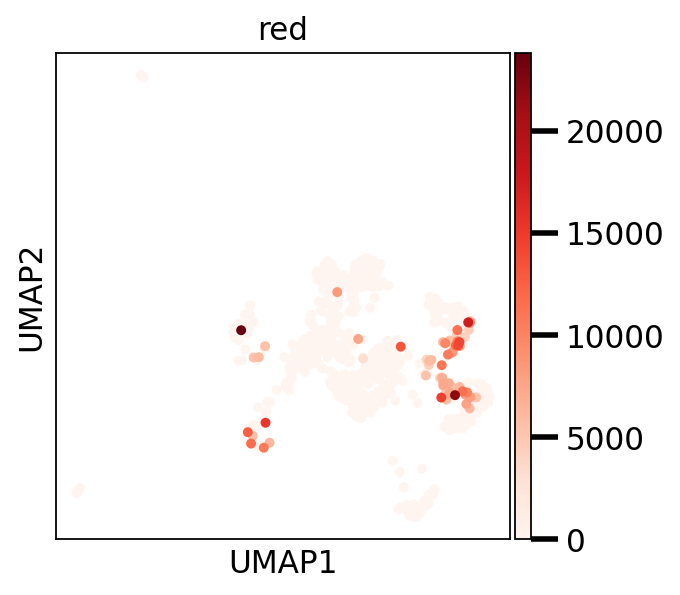

(569, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


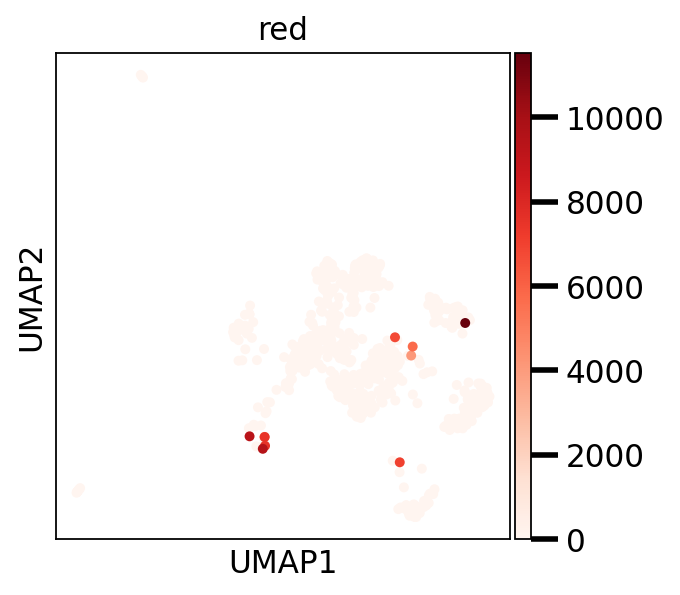

(608, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


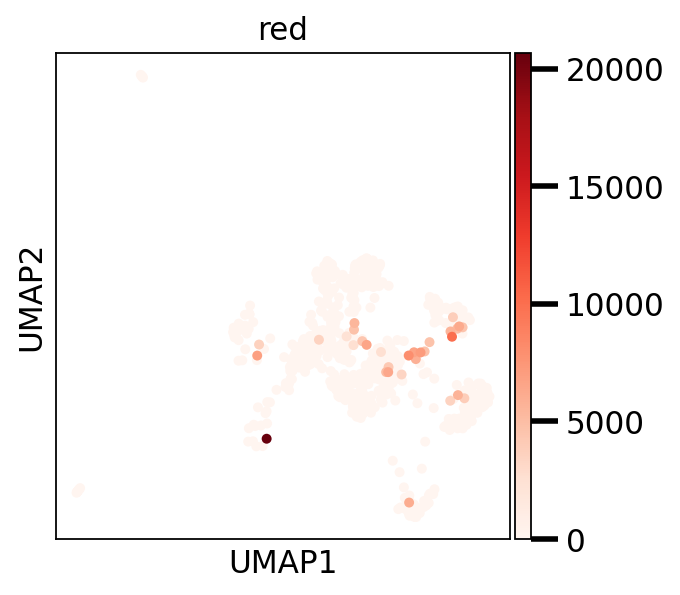

(585, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


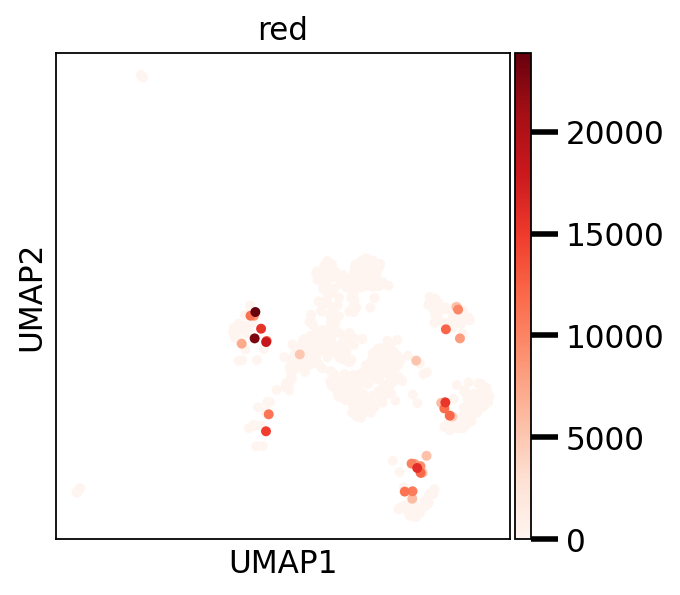

(557, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


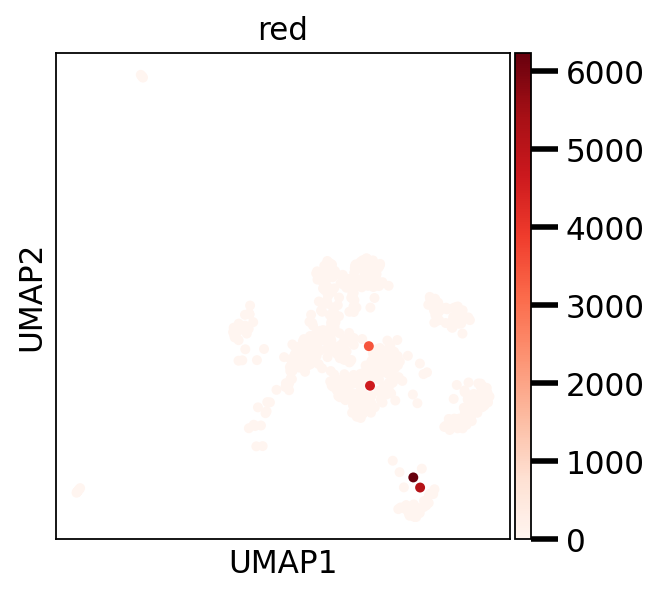

(612, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


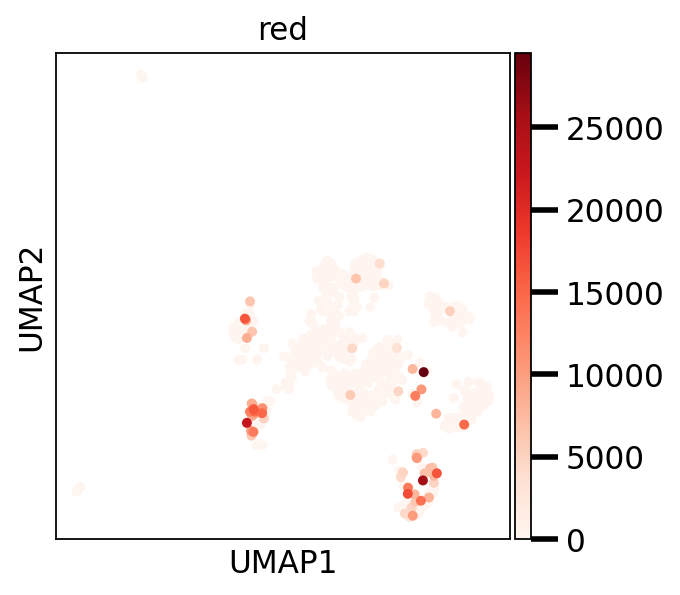

(575, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


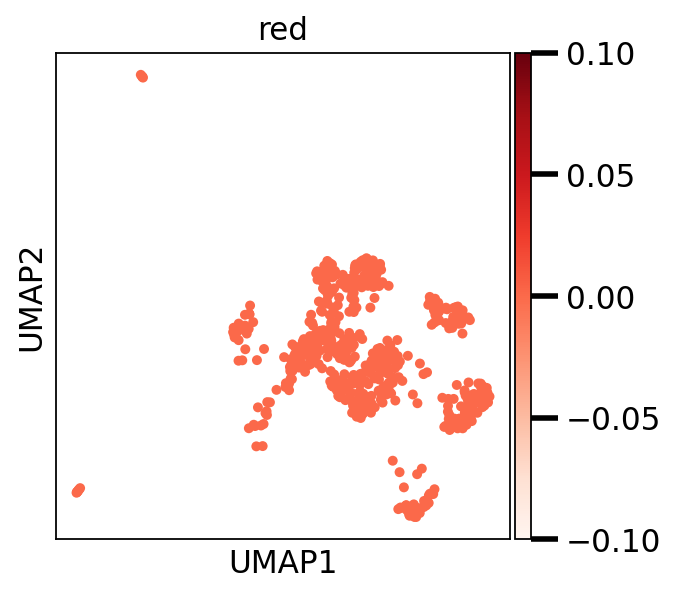

(554, 15000)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


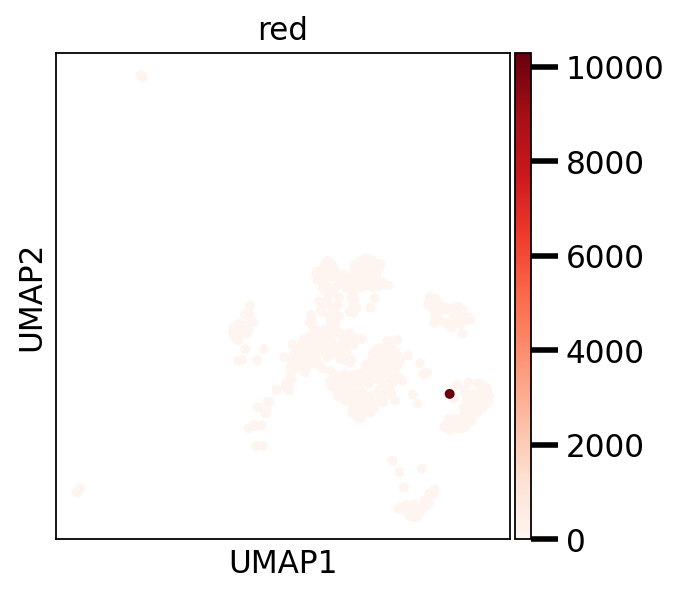

In [12]:
### plotting fluorecence levels stimulus by stimulus
for i in range(1,14):
    index = np.logical_or(adata.obs['stimulus'] == i,adata.obs['stimulus'] == 0)
    aux_adata = adata[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'red', color_map = 'Reds', save = 'UMIs/fluorecence/stimulus_red_' + labels[i]+ '.png', size = 80)
